In [3]:
# preamble: packages we need
from pandas import DataFrame, Series
import pandas as pd
import pandas.io.data as web
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import cPickle as pickle
import csv
from sklearn import cluster
import pylab as pl


%matplotlib inline

# so as not to kill the internet connection, I've saved the data from yahoo to disk
load_from_disk = True
filename = 'yahoo_data.p'
if 'price_data' in locals():
    pass
elif load_from_disk:
    with open(filename, 'rb') as p:
        price_data = pickle.load(p)
    with open('constituents.csv', 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        all_sectors = dict()
        for row in reader:
            all_sectors[row['Symbol']] = row['Sector']
else:
    # here is how you would get the data from the web
    # I got this file from here: http://data.okfn.org/data/core/s-and-p-500-companies
    with open('constituents.csv', 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            all_tickers.append(row['Symbol'])
            all_sectors[row['Symbol']] = row['Sector']
            
    # end date is implicitly today
    start_date = '2001-01-01'
    price_data = {}
    bad_tickers = []
    for ticker in all_tickers:
        try:
            price_data[ticker] = web.get_data_yahoo(ticker, start_date)
        except IOError as ioe:
            bad_tickers.append(ticker)
    print len(bad_tickers), "bad tickers =", bad_tickers
    pickle.dump(price_data, open(filename, 'wb'))
    

price = DataFrame({tic: data['Adj Close'] for tic, data in price_data.iteritems()})
print price.columns
print len(price.keys())
raw_returns = price.pct_change().apply(np.log1p).fillna(0.0)#['2011-01-01':,:]
n_days = max(raw_returns.count())
returns = raw_returns.copy()
missing_tickers = []
for k in returns:
    if returns[k].count() != n_days:
        missing_tickers.append(k)
        del returns[k]
        
print type(returns)
df = returns.as_matrix().transpose()
#plt.plot(df[3,:])
#plt.show()

Index([u'A', u'AA', u'AAPL', u'ABBV', u'ABC', u'ABT', u'ACE', u'ACN', u'ACT',
       u'ADBE', 
       ...
       u'XLNX', u'XOM', u'XRAY', u'XRX', u'XYL', u'YHOO', u'YUM', u'ZION',
       u'ZMH', u'ZTS'],
      dtype='object', length=491)
491
<class 'pandas.core.frame.DataFrame'>


In [4]:
print df.shape
normed = ((df.T-df.mean(axis=1) )/ df.std(axis=1)).T

(491, 3713)


In [5]:
print 'running...'
k = 9
km = cluster.KMeans(n_clusters=k)
km.fit(normed)

labels = km.labels_
print 'done'

running...
done


In [6]:
d = dict()
sector_names = ['Industrials', 'Health Care', 'Information Technology', 'Financials', 'Utilities', 'Materials', 'Consumer Staples', 'Consumer Discretionary','Energy','Telecommunication Services']
for sector in sector_names:
    d[sector] = np.zeros([k])
real_labels = []
i=0
for ticker in price.keys():
    sector = all_sectors[ticker]
    real_labels.append(sector_names.index(sector))
    d[sector][int(labels[i])] = d[sector][int(labels[i])]+1
    i+=1
for key, value in d.items():
    print '%35s'%key,'\t',
    print value
    

                        Industrials 	[  4.  53.   0.   0.   0.   0.   5.   1.   0.]
         Telecommunication Services 	[ 0.  5.  0.  0.  0.  0.  0.  0.  0.]
             Consumer Discretionary 	[  7.  45.   1.   0.   0.   2.   0.   1.  26.]
                          Utilities 	[  0.   1.   0.   1.  27.   0.   0.   0.   0.]
                   Consumer Staples 	[  2.   4.   0.   0.   0.   0.  29.   0.   3.]
                        Health Care 	[  4.   3.   0.   0.   0.   7.  39.   0.   0.]
                          Materials 	[  1.  24.   0.   4.   0.   0.   0.   0.   0.]
             Information Technology 	[  3.  18.   0.   0.   0.  42.   0.   2.   0.]
                             Energy 	[  4.   0.   0.  39.   0.   0.   0.   0.   0.]
                         Financials 	[  1.   6.  18.   0.   0.   2.   0.  57.   0.]


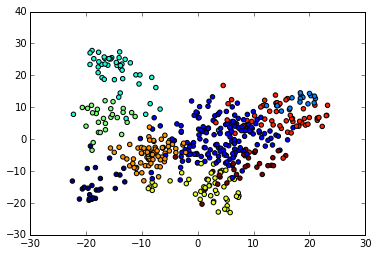

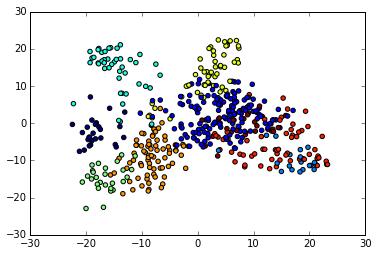

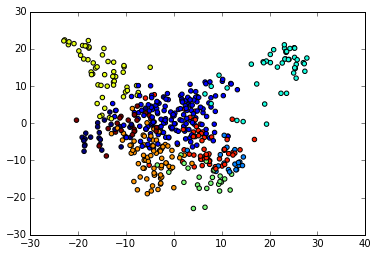

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_r = pca.fit(normed).transform(normed)
plt.figure()
plt.scatter(X_r[:,0],X_r[:,1],c=labels)
plt.figure()
plt.scatter(X_r[:,0],X_r[:,2],c=labels)
plt.figure()
plt.scatter(X_r[:,1],X_r[:,2],c=labels)
plt.show()

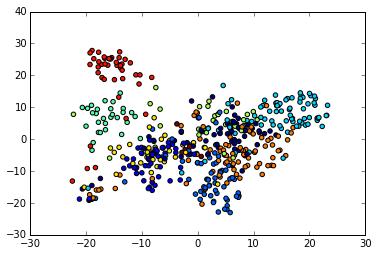

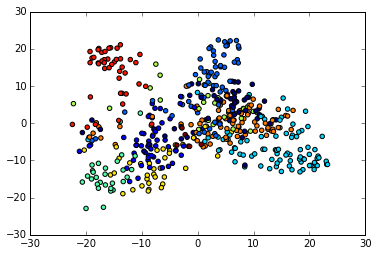

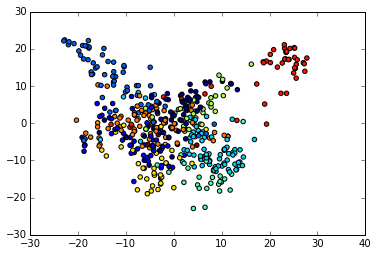

In [8]:
plt.figure()
plt.scatter(X_r[:,0],X_r[:,1],c=real_labels)
plt.figure()
plt.scatter(X_r[:,0],X_r[:,2],c=real_labels)
plt.figure()
plt.scatter(X_r[:,1],X_r[:,2],c=real_labels)
plt.show()